# Content Based Recommender System

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

# Read the data

In [2]:
df = pd.read_csv("anime.csv")
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
df.shape

(12294, 7)

In [4]:
df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

We only want to build recommender based on the genre and the type, so let's focus only to those feature.

# Handling Missing Value

## Handling missing rating

In [5]:
df.loc[df['rating'].isnull(), 'rating'] = 0.0
df['rating'].isnull().any()

False

## Handling missing type


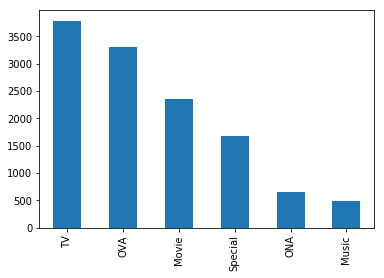

In [6]:
df['type'].value_counts().plot.bar()

My approach is to fill the missing type based on the number of the episodes. But after checking the data, some of the anime have 'unknown' episodes and missing type.

In [7]:
df.loc[(df['episodes']=="Unknown") & (df['type'].isnull())].head()

,anime_id,name,genre,type,episodes,rating,members
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,0.0,60999
10900,34437,Code Geass: Fukkatsu no Lelouch,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",NaN,Unknown,0.0,22748
10906,33352,Violet Evergarden,"Drama, Fantasy",NaN,Unknown,0.0,20564
10907,33248,K: Seven Stories,"Action, Drama, Super Power, Supernatural",NaN,Unknown,0.0,22133
10918,33845,Free! (Shinsaku),"School, Sports",NaN,Unknown,0.0,8666


In [8]:
missing = df.loc[(df['episodes']=="Unknown") & (df['type'].isnull())].copy()
missing.shape

(25, 7)

It seems the data is not up to date with the current season. There is no other way, We have to manually fill the type and the episodes.

In [9]:
missing.head(25)

,anime_id,name,genre,type,episodes,rating,members
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,0.0,60999
10900,34437,Code Geass: Fukkatsu no Lelouch,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",NaN,Unknown,0.0,22748
10906,33352,Violet Evergarden,"Drama, Fantasy",NaN,Unknown,0.0,20564
10907,33248,K: Seven Stories,"Action, Drama, Super Power, Supernatural",NaN,Unknown,0.0,22133
10918,33845,Free! (Shinsaku),"School, Sports",NaN,Unknown,0.0,8666
10949,33475,Busou Shoujo Machiavellianism,"Action, School, Shounen",NaN,Unknown,0.0,1896
10963,31456,Code:Realize: Sousei no Himegimi,"Adventure, Fantasy, Romance, Shoujo",NaN,Unknown,0.0,4017
10983,34332,Flying Babies,NaN,NaN,Unknown,0.0,22
10988,34280,Gamers!,"Comedy, Romance, School",NaN,Unknown,0.0,1045
10990,34485,Ganko-chan,NaN,NaN,Unknown,0.0,11


In [10]:
df.loc[(df['name'] == "Steins;Gate 0"), 'type'] = 'TV'
df.loc[(df['name'] == "Steins;Gate 0"), 'episodes'] = '23'
df.loc[(df['name'] == "Violet Evergarden"), 'type'] = 'TV'
df.loc[(df['name'] == "Violet Evergarden"), 'episodes'] = '13'
df.loc[(df['name'] == "Code Geass: Fukkatsu no Lelouch"), 'type'] = 'TV'
df.loc[(df['name'] == "Code Geass: Fukkatsu no Lelouch"), 'episodes'] = '25'
df.loc[(df['name'] == "K: Seven Stories"), 'type'] = 'Movie'
df.loc[(df['name'] == "K: Seven Stories"), 'episodes'] = '6'
df.loc[(df['name'] == "Free! (Shinsaku)"), 'type'] = 'TV'
df.loc[(df['name'] == "Free! (Shinsaku)"), 'episodes'] = '12'
df.loc[(df['name'] == "Busou Shoujo Machiavellianism"), 'type'] = 'TV'
df.loc[(df['name'] == "Busou Shoujo Machiavellianism"), 'episodes'] = '12'
df.loc[(df['name'] == "Code:Realize: Sousei no Himegimi"), 'type'] = 'TV'
df.loc[(df['name'] == "Code:Realize: Sousei no Himegimi"), 'episodes'] = '12'
df.loc[(df['name'] == "Gamers!"), 'type'] = 'TV'
df.loc[(df['name'] == "Gamers!"), 'episodes'] = '12'
df.loc[(df['name'] == "Ganko-chan"), 'type'] = 'TV'
df.loc[(df['name'] == "Ganko-chan"), 'episodes'] = '10'
df.loc[(df['name'] == "Ginga Eiyuu Densetsu (2017)"), 'type'] = 'OVA'
df.loc[(df['name'] == "Ginga Eiyuu Densetsu (2017)"), 'episodes'] = '110'
df.loc[(df['name'] == "Grancrest Senki"), 'type'] = 'TV'
df.loc[(df['name'] == "Grancrest Senki"), 'episodes'] = '24'
df.loc[(df['name'] == "IDOLiSH7"), 'type'] = 'TV'
df.loc[(df['name'] == "IDOLiSH7"), 'episodes'] = '17'
df.loc[(df['name'] == "Isekai Shokudou"), 'type'] = 'TV'
df.loc[(df['name'] == "Isekai Shokudou"), 'episodes'] = '12'
df.loc[(df['name'] == "Oushitsu Kyoushi Haine"), 'type'] = 'TV'
df.loc[(df['name'] == "Oushitsu Kyoushi Haine"), 'episodes'] = '12'
df.loc[(df['name'] == "Peace Maker Kurogane (Shinsaku)"), 'type'] = 'TV'
df.loc[(df['name'] == "Peace Maker Kurogane (Shinsaku)"), 'episodes'] = '24'
df.loc[(df['name'] == "Seikaisuru Kado"), 'type'] = 'TV'
df.loc[(df['name'] == "Seikaisuru Kado"), 'episodes'] = '12'
df.loc[(df['name'] == "UQ Holder!"), 'type'] = 'TV'
df.loc[(df['name'] == "UQ Holder!"), 'episodes'] = '12'
df.loc[(df['name'] == "Citrus"), 'type'] = 'TV'
df.loc[(df['name'] == "Citrus"), 'episodes'] = '12'
df.loc[(df['name'] == "Hitorijime My Hero"), 'type'] = 'TV'
df.loc[(df['name'] == "Hitorijime My Hero"), 'episodes'] = '12'
df.loc[(df['name'] == "Gekidol"), 'type'] = 'TV'
df.loc[(df['name'] == "Gekidol"), 'episodes'] = '12'
df.loc[(df['name'] == "Flying Babies"), 'type'] = 'OVA'
df.loc[(df['name'] == "Flying Babies"), 'episodes'] = '10'
df.loc[(df['name'] == "Ginga Jinpuu Jinraiger"), 'type'] = 'OVA'
df.loc[(df['name'] == "Ginga Jinpuu Jinraiger"), 'episodes'] = '10'
df.loc[(df['name'] == "Mirai Arise"), 'type'] = 'OVA'
df.loc[(df['name'] == "Mirai Arise"), 'episodes'] = '10'
df.loc[(df['name'] == "Project758"), 'type'] = 'OVA'
df.loc[(df['name'] == "Project758"), 'episodes'] = '10'
df.loc[(df['name'] == "Rescue Academia"), 'type'] = 'OVA'
df.loc[(df['name'] == "Rescue Academia"), 'episodes'] = '10'
df.isnull().sum()

anime_id     0
name         0
genre       62
type         0
episodes     0
rating       0
members      0
dtype: int64

## Handling Unknown Genre

In [11]:
df.isnull().sum()

anime_id     0
name         0
genre       62
type         0
episodes     0
rating       0
members      0
dtype: int64

In [12]:
df[df['genre'].isnull()]

,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607
...,...,...,...,...,...,...,...
11070,32032,Seikaisuru Kado,NaN,TV,12,0.00,1797
11086,34310,Tamagotchi Movie: Tanpen Himitsu no Otodoke Da...,NaN,Movie,1,0.00,51
11097,34474,Tsukipro The Animation,NaN,TV,Unknown,0.00,843
11112,33035,Yuyushiki Special,NaN,Special,1,0.00,2294


For now, let's just fill it with 'Unknown'.

In [13]:
df['genre'].fillna('Unknown', inplace=True)
df.isnull().any()

anime_id    False
name        False
genre       False
type        False
episodes    False
rating      False
members     False
dtype: bool

<br>
# Build the Recommender System

In [14]:
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


## Calculate Weighted Rating

Maybe it is also a good idea to show the weighted rating to the user whenever they query for similiar anime. We can improve the recommendation by sorting the recommendation based on their respective weighted rating.

In [15]:
m = df.members.quantile(0.5)
C = df.rating.mean()
print(m, C)

1550.0 6.35278591182692


In [16]:
def weighted_rating(df, m, C):
    term = df['members'] / (m + df['members'])
    return df['rating'] * term + (1-term) * C

In [17]:
df['community_rating'] = df.apply(weighted_rating, axis=1, args=(m,C))
df.head()

,anime_id,name,genre,type,episodes,rating,members,community_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,9.346869
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,9.254333
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,9.211224
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,9.163532
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,9.131527


## Dropping some unused columns

these are the features that will be dropped:
* anime_id -> just the index of the anime, it is easier if we used the panda's index
* rating -> we have weighted rating (community_rating)
* members -> we have weighted rating (community_rating)
* episodes -> the data that we have is not updated with the current airing anime, and some anime is still airing (One Piece, etc)

In [18]:
df.drop(['anime_id', 'rating', 'members', 'episodes'], axis=1, inplace=True)
df.head()

,name,genre,type,community_rating
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,9.346869
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.254333
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.211224
3,Steins;Gate,"Sci-Fi, Thriller",TV,9.163532
4,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.131527


## Breakdown the genre and type

We want our algorithm to treat the 'type' and 'genre' of anime as equal. Therefore if we use label encoding, maybe the algorithm will treat a certain category more important than the other categories.

In [19]:
df = pd.concat([df, df['type'].str.get_dummies(), df['genre'].str.get_dummies(sep=',')], axis=1)
df.head()

,name,genre,type,community_rating,Movie,Music,ONA,OVA,Special,TV,...,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,9.346869,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.254333,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.211224,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Steins;Gate,"Sci-Fi, Thriller",TV,9.163532,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.131527,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
anime_features = df.loc[:, "Movie":].copy()
anime_features.head()

,Movie,Music,ONA,OVA,Special,TV,Adventure,Cars,Comedy,Dementia,...,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Calculate the similarity matrix

In [21]:
cosine_sim = cosine_similarity(anime_features.values, anime_features.values)

In [22]:
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.31622777],
       [0.        , 1.        , 0.375     , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.375     , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.5       ],
       [0.31622777, 0.        , 0.        , ..., 0.5       , 0.5       ,
        1.        ]])

In [23]:
cosine_sim.shape

(12294, 12294)

Now we must create an indexing for each anime name, this will be used when user querying a recommendation.

In [24]:
anime_index = pd.Series(df.index, index=df.name).drop_duplicates()

In [25]:
def get_recommendation(anime_name, similarity=cosine_sim):
    idx = anime_index[anime_name]
    
    # Get the pairwsie similarity scores of all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar anime
    sim_scores = sim_scores[0:11]

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar anime
    result = df[['name', 'genre', 'community_rating']].iloc[anime_indices].drop(idx)
    return result

In [26]:
get_recommendation("Steins;Gate")

,name,genre,community_rating
10898,Steins;Gate 0,"Sci-Fi, Thriller",0.157426
3581,Fireball Charming,Sci-Fi,6.813410
7984,Hanoka,Sci-Fi,5.267626
8910,Hoshi no Ko Poron,Sci-Fi,6.381367
10079,RoboDz,Sci-Fi,6.251832
10858,Yuusei Kamen,Sci-Fi,6.358220
10975,Escha Chron,Sci-Fi,4.195491
59,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,"Sci-Fi, Thriller",8.591963
126,Steins;Gate: Oukoubakko no Poriomania,"Sci-Fi, Thriller",8.439725
196,Steins;Gate: Kyoukaimenjou no Missing Link - D...,"Sci-Fi, Thriller",8.262408


We see that it is very reasonable that __Steins;Gate 0__ is the most similar anime, because it is the alternate ending of __Steins;Gate__. The rating is very low because __Steins;Gate 0__ was a new anime when the data is collected.

In [27]:
get_recommendation("Kimi no Na wa.")

,name,genre,community_rating
208,Kokoro ga Sakebitagatterunda.,"Drama, Romance, School",8.270178
1494,Harmonie,"Drama, School, Supernatural",7.460836
1959,Air Movie,"Drama, Romance, Supernatural",7.354843
60,Hotarubi no Mori e,"Drama, Romance, Shoujo, Supernatural",8.592418
1199,&quot;Bungaku Shoujo&quot; Movie,"Drama, Mystery, Romance, School",7.583456
2103,Clannad Movie,"Drama, Fantasy, Romance, School",7.334705
5796,Taifuu no Noruda,"Drama, School, Sci-Fi, Supernatural",6.350273
5805,Wind: A Breath of Heart OVA,"Drama, Romance, School, Supernatural",6.351202
6394,Wind: A Breath of Heart (TV),"Drama, Romance, School, Supernatural",6.175358
894,Momo e no Tegami,"Drama, Supernatural",7.711018


In [28]:
get_recommendation("Kokoro ga Sakebitagatterunda.")

,name,genre,community_rating
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.346869
1199,&quot;Bungaku Shoujo&quot; Movie,"Drama, Mystery, Romance, School",7.583456
2103,Clannad Movie,"Drama, Fantasy, Romance, School",7.334705
5697,Shiranpuri (Movie),"Drama, School",6.370936
10123,Samurai,"Drama, Romance",6.167488
1389,Orange: Mirai,"Drama, Romance, School, Sci-Fi, Shoujo",7.500633
3544,Ace wo Nerae! (1979),"Drama, Romance, School, Shoujo, Sports",6.652735
11,Koe no Katachi,"Drama, School, Shounen",9.009910
265,Kaze Tachinu,"Drama, Historical, Romance",8.201966
411,Byousoku 5 Centimeter,"Drama, Romance, Slice of Life",8.091682


In [29]:
get_recommendation("Naruto")

,name,genre,community_rating
615,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",7.935403
175,Katekyo Hitman Reborn!,"Action, Comedy, Shounen, Super Power",8.357958
206,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar...",8.311917
515,Dragon Ball Kai (2014),"Action, Adventure, Comedy, Fantasy, Martial Ar...",7.951906
588,Dragon Ball Kai,"Action, Adventure, Comedy, Fantasy, Martial Ar...",7.929087
1209,Medaka Box Abnormal,"Action, Comedy, Ecchi, Martial Arts, School, S...",7.601109
1930,Dragon Ball Super,"Action, Adventure, Comedy, Fantasy, Martial Ar...",7.385635
2615,Medaka Box,"Action, Comedy, Ecchi, Martial Arts, School, S...",7.198093
3038,Tenjou Tenge,"Action, Comedy, Ecchi, Martial Arts, School, S...",7.088970
178,Boku no Hero Academia,"Action, Comedy, School, Shounen, Super Power",8.349028


In [30]:
get_recommendation("Noragami")

,name,genre,community_rating
113,Noragami Aragoto,"Action, Adventure, Shounen, Supernatural",8.469045
64,JoJo no Kimyou na Bouken: Stardust Crusaders 2...,"Action, Adventure, Drama, Shounen, Supernatural",8.563415
95,JoJo no Kimyou na Bouken (TV),"Action, Adventure, Shounen, Supernatural, Vampire",8.492562
257,JoJo no Kimyou na Bouken: Stardust Crusaders,"Action, Adventure, Drama, Shounen, Supernatural",8.225825
1887,Allison to Lillia,"Action, Adventure, Shounen",7.353729
2475,Dororo to Hyakkimaru,"Action, Adventure, Supernatural",6.751190
3120,Yumekui Merry,"Action, Shounen, Supernatural",7.067577
5028,Kouya no Shounen Isamu,"Action, Adventure, Shounen",6.389860
8640,Gene Diver,"Action, Adventure, Shounen",6.347239
76,JoJo no Kimyou na Bouken: Diamond wa Kudakenai,"Action, Adventure, Comedy, Drama, Shounen, Sup...",8.524556


In [31]:
get_recommendation("Plastic Memories")

,name,genre,community_rating
4084,Ray The Animation,"Drama, Romance, Sci-Fi",6.733847
6366,Seraphim Call,"Drama, Romance, Sci-Fi",6.228895
2279,Saishuu Heiki Kanojo,"Drama, Romance, School, Sci-Fi",7.285106
4002,Ushinawareta Mirai wo Motomete,"Drama, Romance, School, Sci-Fi",6.814940
11079,Shuumatsu Nani Shitemasu ka? Isogashii desu ka...,"Drama, Fantasy, Romance, Sci-Fi",5.467417
1122,Kiznaiver,"Drama, Sci-Fi",7.659764
1548,Winter Sonata,"Drama, Romance",7.391464
5731,Sister Princess: Re Pure,"Drama, Romance",6.366361
11014,Island,"Drama, Sci-Fi",3.068501
168,Planetes,"Drama, Romance, Sci-Fi, Seinen, Space",8.350522
